In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

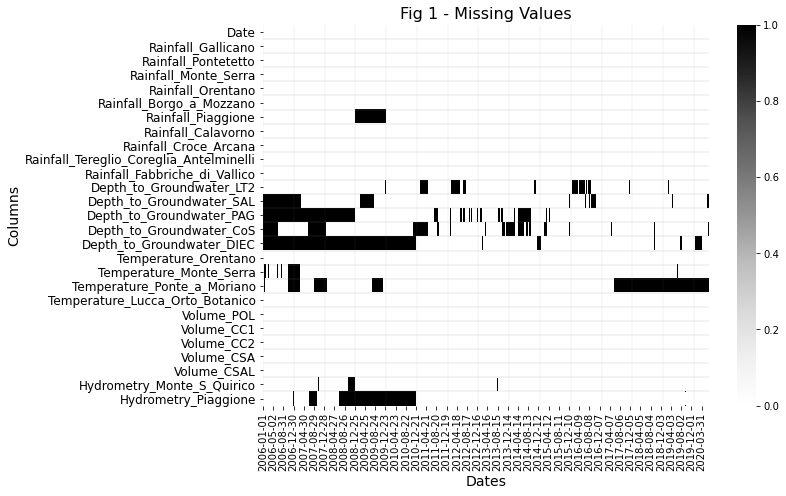

In [2]:
from datetime import datetime, date
# LOADING DATA
def load_data(name):
    df = pd.read_csv(f"input/acea-water-prediction/Aquifer_{name}.csv")
    # Read date in european format
    df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')
    return df

def load_Auser():
    aquifer = load_data("Auser")
    # CLEANING DATA
    #Replacing 0 values in well depth and temperatures with NaN
    # because they are actually  missing values
    for col in aquifer.columns[11:20]:
        aquifer[col] = aquifer[col].replace([0],float('nan'))
    #Getting indexes where the condition (NaN values for Rainfall_Gallicano) is true
    nan_rain = aquifer[aquifer.iloc[:,1].isnull()].index
    #dropping these indexes with NaN values
    aquifer = aquifer.drop(nan_rain)
    #resetting the index (without adding a new column)
    aquifer = aquifer.reset_index(drop=True)
    #There are some nan in Rainfall_Monte_Serra, but they are not so important
    aquifer["Rainfall_Monte_Serra"] = aquifer["Rainfall_Monte_Serra"].fillna(0)
    return aquifer
# FIND MISSING VALUES
def show_missing(df):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
    #Set all the labels on y axis with yticklabels=True
    sns.heatmap(df.T.isna(), cmap='Greys')
    ax.set_title('Fig 1 - Missing Values', fontsize=16)
    ax.set_xlabel("Dates", fontsize=14)
    ax.set_ylabel("Columns", fontsize=14)
    #Extracting x-labels as numbers
    x_labels = [int(tick.get_text()) for tick in ax.get_xticklabels()]
    #Converting indexes to dates
    new_labels = df["Date"].iloc[x_labels]
    new_labels = new_labels.astype('string') #as strinf for best formatting
    #Setting the new labels
    ax.set_xticklabels(new_labels)
    #Setting font size for y labels
    for i in ax.yaxis.get_major_ticks():
        i.label.set_fontsize(12)
    #Adding horizontal and vertical lines (very customizable)
    ax.hlines(range(1,df.shape[1]),0,df.shape[0], linewidth=0.2, colors='gray')
    ax.vlines(range(1,df.shape[0],365),0,df.shape[1], linewidth=0.1, colors='gray')
    plt.show()

aquifer = load_Auser()
show_missing(aquifer)

# Missing data in rainfall
Rainfall data are not bad, we need just ti recover Rainfall_Piaggione (or drop it). We try with a linear regression

In [3]:
def get_std_errors(X_old):
    X = X_old.copy()
    X["intercept"] = 1
    df = X.transpose().dot(X)
    inv = pd.DataFrame(np.linalg.pinv(df.values), df.columns, df.index)
    return np.sqrt(np.diag(inv))

# Print coefficients and Z score as a formatted table
def get_coef_table(reg, features, X_train):
    std_errors =  get_std_errors(X_train)
    format = "%-30s | %+2.5f | %+2.3f"
    format_title = "%-30s | %8s | %6s"
    print (format_title %("feature","coef","Z score"))
    print ("-"*38)
    for i in range((len(features))):
        print(format%(features[i][:30],reg.coef_[i],reg.coef_[i]/std_errors[i]))
    print("Intercept:\n", reg.intercept_)

Predicting Rainfall_Piaggione. R^2 on train = 0.847
Predicting Rainfall_Piaggione. R^2 on test  = 0.849
feature                        |     coef | Z score
--------------------------------------
Rainfall_Gallicano             | -0.05805 | -15.991
Rainfall_Pontetetto            | +0.31901 | +98.211
Rainfall_Monte_Serra           | +0.00000 | +0.000
Rainfall_Orentano              | +0.01954 | +5.713
Rainfall_Borgo_a_Mozzano       | +0.32896 | +92.142
Rainfall_Calavorno             | +0.17853 | +37.476
Rainfall_Croce_Arcana          | +0.00000 | +0.000
Rainfall_Tereglio_Coreglia_Ant | -0.00000 | -0.000
Rainfall_Fabbriche_di_Vallico  | +0.11423 | +33.151
Intercept:
 0.0


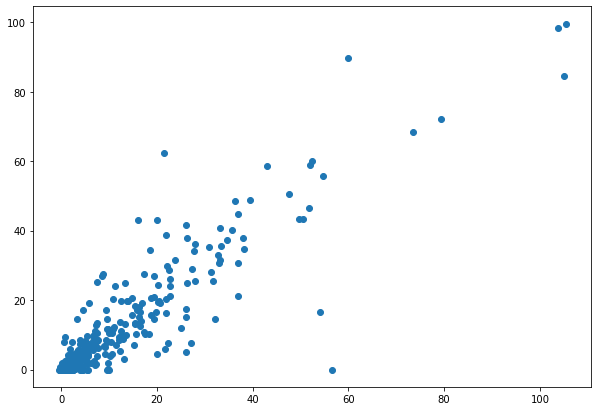

In [4]:
#just rainfall columns without nan values
aquifer = load_Auser()
rain_cols = [col for col in aquifer.columns if col[0:9]=="Rainfall_"]
rain_aquifer = aquifer[rain_cols]
rain_aquifer = rain_aquifer.dropna()
rain_aquifer = rain_aquifer.reset_index(drop=True)

#extract train and test
train = rain_aquifer.sample(frac=0.8,random_state=42) #random state is a seed value
test = rain_aquifer.drop(train.index)
y_train = train["Rainfall_Piaggione"]
y_test = test["Rainfall_Piaggione"]
rain_cols.remove('Rainfall_Piaggione')
x_train = train[rain_cols]
x_test = test[rain_cols]

#fit the model
from sklearn.linear_model import Lasso
# no intercept beacause i want to predict no rain if it rains nowhere
# alpha=2 beacause all coefficients need to be positive
# it make no sense that more rain in a location implies less rain in an other
model = Lasso(alpha=2, fit_intercept=False)
reg = model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Predicting Rainfall_Piaggione. R^2 on train = %2.3f"%(reg.score(x_train, y_train)))
print("Predicting Rainfall_Piaggione. R^2 on test  = %2.3f"%(reg.score(x_test, y_test)))
get_coef_table(reg,rain_cols, x_train)
fig = plt.figure(figsize=(10,7))
plt.scatter(y_pred,y_test)
plt.show()

The estimation is enough for replacing the missing data

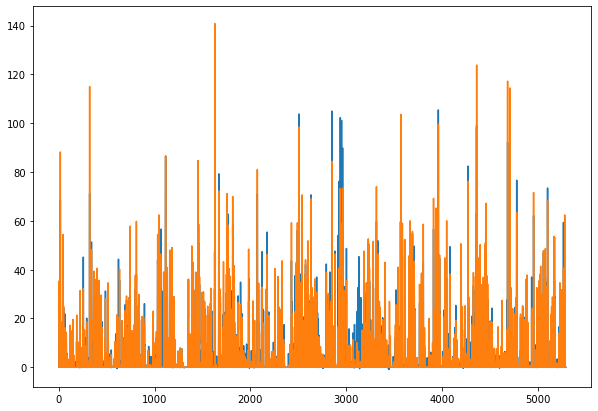

In [5]:
aquifer = load_Auser()
X = aquifer[rain_cols]
y_pred = model.predict(X)
#get index for missing values in Rainfall_Piaggione
missing_Piag = aquifer[aquifer["Rainfall_Piaggione"].isna()].index
#replace the missing data by their prediction
#using loc to avoid SettingWithCopyWarning
aquifer.loc[missing_Piag, "Rainfall_Piaggione"] = y_pred[missing_Piag]

fig = plt.figure(figsize=(10,7))
plt.plot(y_pred)
plt.plot(aquifer["Rainfall_Piaggione"])
plt.show()

# Missing data in temperature

So this is the current situation for missing data:

In [6]:
# We check missing values
for df in (aquifer,):
    print("_____________________")
    for col in df.columns:
        print("NaN values in %s = %2.5f%% " % (col, 100*df[col].isnull().sum()/df.shape[0]))

_____________________
NaN values in Date = 0.00000% 
NaN values in Rainfall_Gallicano = 0.00000% 
NaN values in Rainfall_Pontetetto = 0.00000% 
NaN values in Rainfall_Monte_Serra = 0.00000% 
NaN values in Rainfall_Orentano = 0.00000% 
NaN values in Rainfall_Borgo_a_Mozzano = 0.00000% 
NaN values in Rainfall_Piaggione = 0.00000% 
NaN values in Rainfall_Calavorno = 0.00000% 
NaN values in Rainfall_Croce_Arcana = 0.00000% 
NaN values in Rainfall_Tereglio_Coreglia_Antelminelli = 0.00000% 
NaN values in Rainfall_Fabbriche_di_Vallico = 0.00000% 
NaN values in Depth_to_Groundwater_LT2 = 9.34844% 
NaN values in Depth_to_Groundwater_SAL = 14.35316% 
NaN values in Depth_to_Groundwater_PAG = 28.10198% 
NaN values in Depth_to_Groundwater_CoS = 18.58357% 
NaN values in Depth_to_Groundwater_DIEC = 38.24363% 
NaN values in Temperature_Orentano = 0.01889% 
NaN values in Temperature_Monte_Serra = 4.45703% 
NaN values in Temperature_Ponte_a_Moriano = 29.06516% 
NaN values in Temperature_Lucca_Orto_Botan

In [7]:
x_test.isna().sum()

Rainfall_Gallicano                         0
Rainfall_Pontetetto                        0
Rainfall_Monte_Serra                       0
Rainfall_Orentano                          0
Rainfall_Borgo_a_Mozzano                   0
Rainfall_Calavorno                         0
Rainfall_Croce_Arcana                      0
Rainfall_Tereglio_Coreglia_Antelminelli    0
Rainfall_Fabbriche_di_Vallico              0
dtype: int64

Predicting Temperature_Monte_Serra. R^2 on train = 0.908
Predicting Temperature_Monte_Serra. R^2 on test  = 0.910
feature                        |     coef | Z score
--------------------------------------
Temperature_Orentano           | +0.32210 | +16.904
Temperature_Lucca_Orto_Botanic | +0.57248 | +30.440
Intercept:
 -2.179288624006265


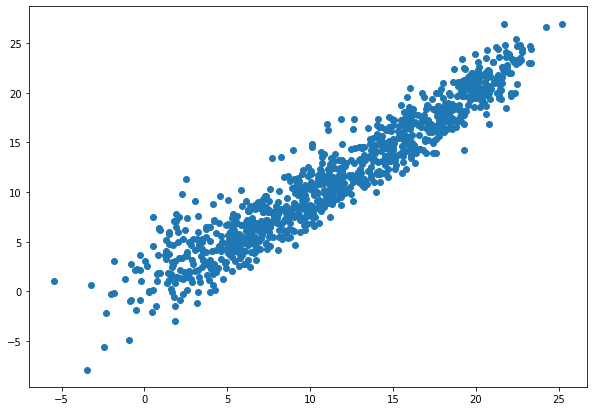

In [8]:
#missing data for Ponte a Moriano are too much, we discard the whole column:**
del aquifer["Temperature_Ponte_a_Moriano"]
#missing data for Lucca_Orto_Botanico and Orentano are very few, we replace them by median
aquifer["Temperature_Orentano"] = aquifer["Temperature_Orentano"].fillna(aquifer["Temperature_Orentano"].median())
aquifer["Temperature_Lucca_Orto_Botanico"] = aquifer["Temperature_Lucca_Orto_Botanico"].fillna(aquifer["Temperature_Lucca_Orto_Botanico"].median())
#We use prediction again for Monte Serra
temp_cols = [col for col in aquifer.columns if col[0:12]=="Temperature_"]
temp_aquifer = aquifer[temp_cols].dropna()
train = temp_aquifer.sample(frac=0.8,random_state=2) #random state is a seed value
test = temp_aquifer.drop(train.index)

temp_aquifer = aquifer[temp_cols]
y_train = train["Temperature_Monte_Serra"]
y_test = test["Temperature_Monte_Serra"]
temp_cols.remove('Temperature_Monte_Serra')
x_train = train[temp_cols]
x_test = test[temp_cols]



#fit the model
from sklearn.linear_model import LinearRegression
#no need for a Lasso
model = LinearRegression()
reg = model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Predicting Temperature_Monte_Serra. R^2 on train = %2.3f"%(reg.score(x_train, y_train)))
print("Predicting Temperature_Monte_Serra. R^2 on test  = %2.3f"%(reg.score(x_test, y_test)))
get_coef_table(reg,temp_cols, x_train)
fig = plt.figure(figsize=(10,7))
plt.scatter(y_pred,y_test)
plt.show()

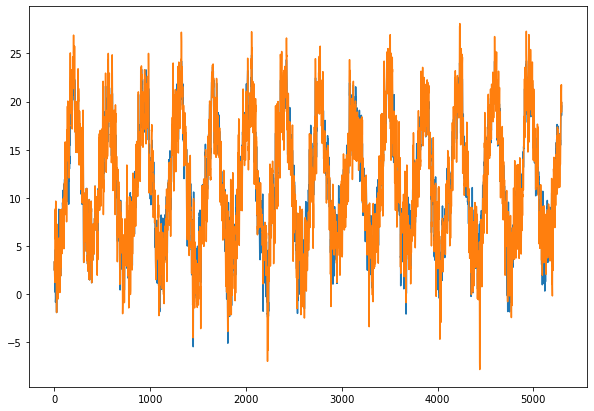

In [9]:
X = aquifer[temp_cols]
y_pred = model.predict(X)
#get index for missing values in Temperature_Monte_Serra
missing_Mont = aquifer[aquifer["Temperature_Monte_Serra"].isna()].index
#replace the missing data by their prediction
#using loc to avoid SettingWithCopyWarning
aquifer.loc[missing_Mont, "Temperature_Monte_Serra"] = y_pred[missing_Mont]

fig = plt.figure(figsize=(10,7))
plt.plot(y_pred)
plt.plot(aquifer["Temperature_Monte_Serra"])
plt.show()

In [10]:
# We check missing values
for df in (aquifer,):
    print("_____________________")
    for col in df.columns:
        print("NaN values in %s = %2.5f%% " % (col, 100*df[col].isnull().sum()/df.shape[0]))

_____________________
NaN values in Date = 0.00000% 
NaN values in Rainfall_Gallicano = 0.00000% 
NaN values in Rainfall_Pontetetto = 0.00000% 
NaN values in Rainfall_Monte_Serra = 0.00000% 
NaN values in Rainfall_Orentano = 0.00000% 
NaN values in Rainfall_Borgo_a_Mozzano = 0.00000% 
NaN values in Rainfall_Piaggione = 0.00000% 
NaN values in Rainfall_Calavorno = 0.00000% 
NaN values in Rainfall_Croce_Arcana = 0.00000% 
NaN values in Rainfall_Tereglio_Coreglia_Antelminelli = 0.00000% 
NaN values in Rainfall_Fabbriche_di_Vallico = 0.00000% 
NaN values in Depth_to_Groundwater_LT2 = 9.34844% 
NaN values in Depth_to_Groundwater_SAL = 14.35316% 
NaN values in Depth_to_Groundwater_PAG = 28.10198% 
NaN values in Depth_to_Groundwater_CoS = 18.58357% 
NaN values in Depth_to_Groundwater_DIEC = 38.24363% 
NaN values in Temperature_Orentano = 0.00000% 
NaN values in Temperature_Monte_Serra = 0.00000% 
NaN values in Temperature_Lucca_Orto_Botanico = 0.00000% 
NaN values in Volume_POL = 0.00000% 
Na

In [13]:
#Formatting data

from patsy import dmatrices, dmatrix, demo_data
def extract_col(df, substr):
    return [col for col in df.columns if substr in col]

def format_rain(aquifer_old,days, k):
    aquifer = aquifer_old.copy()
    #Calculating total rain
    rain_name = extract_col(aquifer, 'Rainfall_')
    #aquifer["tot_rain"] = aquifer[rain_name].sum(axis=1)

    max_day_before = days #select how long keep old rain record
    for d in range(1, max_day_before + k):
        for col in rain_name:
            aquifer[col+"_"+str(d)] = aquifer[col].shift(d)

    temp_name = extract_col(aquifer, 'Temperature_')
    aquifer["mean_temp"] = aquifer[temp_name].mean(axis=1)
    for d in range(1, max_day_before+2):
        aquifer["mean_temp"+"_"+str(d)] = aquifer["mean_temp"].shift(d)
    mean_temp_name = extract_col(aquifer, 'mean_temp')
    aquifer["tot_mean_temp"] = aquifer[mean_temp_name].mean(axis=1)

    vol_name = extract_col(aquifer, 'Volume_')
    for col in vol_name:
        aquifer[col +"_mean_"+str(days)] = 0
        for d in range(1, max_day_before):
            aquifer[col +"_mean_"+str(days)] += aquifer[col].shift(d)

    wells_name = extract_col(aquifer, 'Depth_to_')
    for col in wells_name:
        aquifer[col+"_old_"+str(max_day_before)] = aquifer[col].shift(max_day_before)
        aquifer[col+"_delta_"+str(max_day_before)] = aquifer[col] - aquifer[col+"_old_"+str(max_day_before)]

    #Delete initial rows with Nan values
    aquifer = aquifer.iloc[max_day_before+1:]
    return aquifer
print("function loaded")

function loaded


# Selecting rainfall localities

In [15]:
aquifer_10d = format_rain(aquifer, 10, k=2)
print(aquifer_10d.columns)

Index(['Date', 'Rainfall_Gallicano', 'Rainfall_Pontetetto',
       'Rainfall_Monte_Serra', 'Rainfall_Orentano', 'Rainfall_Borgo_a_Mozzano',
       'Rainfall_Piaggione', 'Rainfall_Calavorno', 'Rainfall_Croce_Arcana',
       'Rainfall_Tereglio_Coreglia_Antelminelli',
       ...
       'Depth_to_Groundwater_LT2_old_10', 'Depth_to_Groundwater_LT2_delta_10',
       'Depth_to_Groundwater_SAL_old_10', 'Depth_to_Groundwater_SAL_delta_10',
       'Depth_to_Groundwater_PAG_old_10', 'Depth_to_Groundwater_PAG_delta_10',
       'Depth_to_Groundwater_CoS_old_10', 'Depth_to_Groundwater_CoS_delta_10',
       'Depth_to_Groundwater_DIEC_old_10',
       'Depth_to_Groundwater_DIEC_delta_10'],
      dtype='object', length=164)


In [18]:
#--------------------
# ULTIMA VERSIONE
#--------------------


def extract_features(aquifer, well_target):
    #Extracting all features names
    features_rain = extract_col(aquifer, 'Rainfall')#_Monte_Serra') + extract_col(aquifer_10d, 'Rainfall_Pontetetto')  + extract_col(aquifer_10d, 'Rainfall_Fabbriche')
    features_temp = extract_col(aquifer, 'tot_mean_temp')
    features_vol = extract_col(aquifer, 'Volume')
    features_well = extract_col(aquifer, well_target +"_old_"+str(days))
    features_date = extract_col(aquifer, 'day_year')
    features_time = extract_col(aquifer, 'days_from_begin')

    return features_vol, features_rain, features_well, features_temp, features_date, features_time

#FORMATTING PATSY FORMULA FOR GETTING x AND y
def format_feature( feature_list, formato):
        return " + ".join([formato.format(col) for col in feature_list])

def preprocess_aquifer(aquifer_feat, target, format_target, features_list, format_list):
    # standardise and extracting features (only positive values, with classic sdv)
    target_formula = format_feature([target], format_target)
    formulas = []
    for feature, formato in zip(features_list, format_list):
        formula = format_feature(feature, formato)
        formulas.append(formula)
    features_formula = " + ".join(formulas)
    #no intercept beacause of lasso
    final_formula = F"{target_formula} ~ {features_formula} -1"
    y, x = dmatrices(final_formula, aquifer_feat, return_type='dataframe')
    #Extracting x and y
    x = x.reset_index(drop=True)
    y = y.reset_index(drop=True)
    return x, y

def preprocess_features(aquifer_feat, features_list, format_list):
    # standardise and extracting features (only positive values, with classic sdv)

    formulas = []
    for feature, formato in zip(features_list, format_list):
        formula = format_feature(feature, formato)
        formulas.append(formula)
    features_formula = " + ".join(formulas)
    #no intercept beacause of lasso
    final_formula = F"{features_formula} -1"

    x = dmatrix(final_formula, aquifer_feat, return_type='dataframe')
    #Reset index
    x = x.reset_index(drop=True)
    return x

def preprocess_target(aquifer_target, target, format_target):
    # standardise and extracting features (only positive values, with classic sdv)
    target_formula = format_feature([target], format_target)

    final_formula = F"{target_formula} -1"

    #print(aquifer_feat[target])
    y = dmatrix(final_formula, aquifer_target.dropna(), return_type='dataframe')
    #Reset index
    y = y.reset_index(drop=True)
    return y



 #detect automatically the features groups
def get_groups(features, end):
   groups_name = []
   groups = []
   for feat in features:
        classed = False
        i=-1
        for i, group in enumerate(groups_name):
            if feat[0:len(group)]==group:
                groups.append(i)
                classed = True
        if not classed:
            groups_name.append(feat[:-end])
            groups.append(i+1)
        if 'day_year' in feat:
            #no regularisation for season feature
            groups[-1] = -1
   return groups, groups_name



def plot_coef(coef, groups, groups_name):
    group_dict = { name : [] for name in groups_name }
    for coef, gr in zip(coef, groups):
        group_dict[groups_name[gr]].append(coef[0])
    fig, ax = plt.subplots(figsize=(10,7))
    for name in groups_name:
        #we plot just the rainfall
        if  not 'Rainfall' in name:
            continue
        ax.plot(group_dict[name], label=name)
        ax.legend(bbox_to_anchor=(0.78, 1), loc='upper left')
def plot_feature_dependencies():
    spline_features = features_well + features_temp + features_time + features_date + features_vol
    for i, name in enumerate(spline_features):
        feat_cols = []
        feat_coefs = []
        for coef, gr in zip(reg.coef_, x.columns):
            if name in gr:

                feat_cols.append(gr)
                feat_coefs.append(coef)

        feat_y = x[feat_cols]@feat_coefs
        feat_x =aquifer_10d_feat[name]

        if i==0:
            feat_x = (feat_x - feat_x.mean())/feat_x.std()
        ax_feat[i].scatter(x=feat_x, y=feat_y, label=well_target, s=0.1)


#fig_feat, ax_feat = plt.subplots(nrows=9, ncols=1, figsize=(14,30))

days = 10
aquifer_10d = format_rain(aquifer, days, k=2)
#aquifer_10d = aquifer_10d.iloc[round(aquifer_10d.shape[0]*0.5):] #use only recent data
#add season feature
aquifer_10d["day_year"] = aquifer_10d["Date"].dt.dayofyear

aquifer_10d["days_from_begin"] = aquifer_10d["Date"] - aquifer_10d["Date"].iloc[0]
aquifer_10d["days_from_begin"] = aquifer_10d["days_from_begin"].dt.days
#set well target
well_list = extract_col(aquifer, "Depth")
well_target = "Depth_to_Groundwater_CoS" #R^2 = 0.70
#well_target = "Depth_to_Groundwater_PAG" #R^2 = 0.82


choose_features = [False, True, True, True, True, False]
def get_R2_scores(aquifer, aquifer_10d, choose_features):

    def best_lowdf_index(clf):
        best_ind = clf.best_index_
        bound = means[best_ind] - stds[best_ind]
        new_best_ind = best_ind
        def get_df(ind):
            return 1/clf.cv_results_['params'][ind]['group_reg']
        for ind, mean in enumerate(means):
            if means[ind]>bound and get_df(ind)<get_df(new_best_ind):
                new_best_ind = ind
        return new_best_ind


    R2_scores = []
    well_list = extract_col(aquifer, "Depth")
    for well_target in well_list:
        print("Preprocessing features...")
        #classify features
        classified_features = extract_features(aquifer_10d, well_target)

        #features_vol, features_rain, features_well, features_temp, features_date, features_time
        class_feat_names = ["Volume", "Rainfall", "Well_depth", "Temperature", "Day_of_year", "Time"]
        format_list = ["standardize({}, center=True, ddof=1)",#just a (standardized) constant for Volume and Rainfall
                           "standardize({}, center=False, ddof=1)",
                           "cr(standardize({}, center=True, ddof=1), df=6)",#natural spline for complex features
                           "cr(standardize({}, center=True, ddof=1), df=6)",
                           "cc(standardize({}, center=True, ddof=1), df=6)", #cyclic spline for day_of year
                           "cr(standardize({}, center=True, ddof=1), df=3)"]
        #Selecting features to use in prediction
        filt_format_list = []
        filt_classified_features = []
        target = well_target +"_delta_"+str(days)
        features = [target]
        features
        for class_feat, flag, class_feat_name, formato in zip(classified_features, choose_features, class_feat_names, format_list):
            print(f"Set {class_feat_name} to {flag}")
            if flag:
                filt_classified_features += [class_feat]
                features += class_feat
                filt_format_list += [formato]

        aquifer_10d_feat = aquifer_10d[features].dropna()

        x = preprocess_features(aquifer_10d_feat, filt_classified_features, filt_format_list)
        proc_features = x.columns
        #classify automatically groups
        groups, groups_name = get_groups(proc_features, 27)

        print(f"Analysing {well_target}")

        y = preprocess_target(pd.DataFrame(aquifer_10d_feat), target, "standardize({}, center=False, ddof=1)")

        #print(proc_features)
        #sampling train and test
        x_train = x.sample(frac=0.6,random_state=1) #with shuffle


        x_train = x.iloc[:round(x.shape[0]*0.8)] #without shuffle
        x_test = x.drop(x_train.index)
        #for test we use the same time information the last train time
        for col in extract_col(x, "days_from_begin"):
            x_test[col] = x_train[col].iloc[-1]
        y_train = y.iloc[x_train.index, :]
        y_test = y.iloc[x_test.index, :]

        #Grouped lasso with crossvalidation
        print("Start Grid search with Grouped Lasso...")
        from group_lasso import GroupLasso
        model = GroupLasso(
            groups=groups,
            frobenius_lipschitz=True,
            subsampling_scheme=1,
            supress_warning=True,
            n_iter=1000,
            tol=1e-3,
        )
        from sklearn.model_selection import GridSearchCV
        parameters = { 'group_reg':[0.005, 0.01, 0.025, 0.05, 0.075,  0.1, 0.25, 0.5], 'l1_reg':[0.001], 'groups':[groups]}
        clf = GridSearchCV(model, parameters, verbose=1)
        clf.fit(x_train, y_train)

        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        #Get best hyperparameters with highest group coefficient (i.e. less degree of freedom)
        new_best_ind = best_lowdf_index(clf)
        #This is the best choice for the model
        best_group_reg = clf.cv_results_['params'][new_best_ind]['group_reg']
        print(f"Choosing group_reg = {best_group_reg}")
        best_model = GroupLasso(
            groups=groups,
            group_reg=clf.cv_results_['params'][new_best_ind]['group_reg'],
            l1_reg=clf.cv_results_['params'][new_best_ind]['l1_reg'],
            frobenius_lipschitz=True,
            scale_reg="inverse_group_size",
            subsampling_scheme=1,
            supress_warning=True,
            n_iter=1000,
            tol=1e-3)
        #fitting over all the train set
        reg = best_model.fit(x_train, y_train)
        print("R^2 score on train = %2.3f"%(reg.score(x_train, y_train)))
        print("R^2 score on test  = %2.3f"%(reg.score(x_test, y_test)))
        R2_scores.append(reg.score(x_test, y_test))
    return well_list, R2_scores
    # Plotting the coefficients over a graph (just for rainfall)
    #plot_coef(reg.coef_, groups, groups_name)
    #plt.show()
    #plot_feature_dependencies()
    #plt.show()

#features_vol, features_rain, features_well, features_temp, features_date, features_time
min_feat = [False, True, True, False, True, False]
all_feat = [True, True, True, True, True, True]
withtemp_feat = [False, True, True, True, True, False]

select_list = [min_feat, all_feat, withtemp_feat]
all_R2 = []
for choose_features in select_list:
    well_list, R2 = get_R2_scores(aquifer, aquifer_10d, choose_features)
    all_R2.append(R2)

Preprocessing features...
Set Volume to False
Set Rainfall to True
Set Well_depth to True
Set Temperature to False
Set Day_of_year to True
Set Time to False
Analysing Depth_to_Groundwater_LT2
Start Grid search with Grouped Lasso...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Choosing group_reg = 0.025
R^2 score on train = 0.363
R^2 score on test  = 0.372
Preprocessing features...
Set Volume to False
Set Rainfall to True
Set Well_depth to True
Set Temperature to False
Set Day_of_year to True
Set Time to False
Analysing Depth_to_Groundwater_SAL
Start Grid search with Grouped Lasso...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Choosing group_reg = 0.025
R^2 score on train = 0.627
R^2 score on test  = 0.747
Preprocessing features...
Set Volume to False
Set Rainfall to True
Set Well_depth to True
Set Temperature to False
Set Day_of_year to True
Set Time to False
Analysing Depth_to_Groundwater_PAG
Start Grid search with Grouped Lasso...
Fitting 5 folds for ea

In [ ]:
print(np.array(all_R2).T)
print(np.c_[all_R2[0], all_R2[1], all_R2[2]])

                           min_feat  all_feat  with_temp
Depth_to_Groundwater_LT2   0.372490  0.089901   0.365304
Depth_to_Groundwater_SAL   0.746542  0.761980   0.746573
Depth_to_Groundwater_PAG   0.801173  0.799816   0.802985
Depth_to_Groundwater_CoS   0.643349  0.624890   0.651212
Depth_to_Groundwater_DIEC  0.748676  0.760231   0.748941


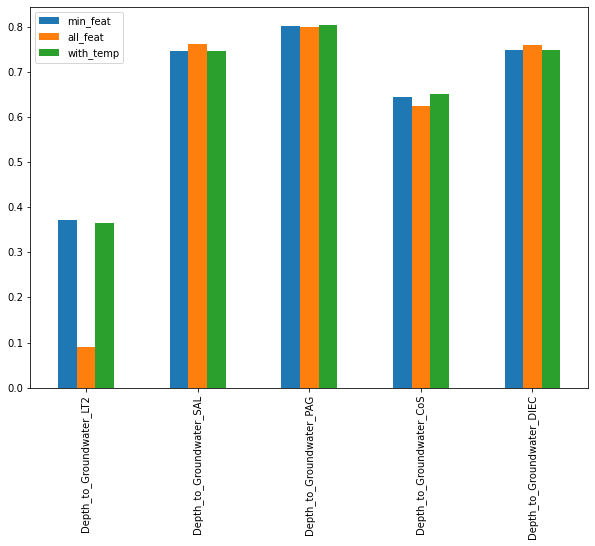

In [29]:
names = ["min_feat","all_feat","with_temp"]
X = well_list
Y = R2
Z = R2

df = pd.DataFrame(np.array(all_R2).T, index=well_list)
df.columns = names.copy()
print(df)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
df.plot.bar(ax=ax)

plt.show()
fig.savefig(f"graphs/Auser_R2_compare.png", bbox_inches='tight')

# FIND MISSING VALUES




